In [1]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import ast
import pathlib
import time
%matplotlib inline

In [2]:
# turn response caching on and turn on logging to your terminal window
ox.config(log_console=True, use_cache=True)

ox.__version__

'1.0.0'

# Load and merge AGEB road network stats and Census data

In [24]:
ageb_inegi = gpd.read_file('merida_kanasing_ageb_censo_data/merida_kanasing_ageb_censo_data.shp')
stats_ageb = pd.read_csv('stats_every_ageb.csv', encoding='utf-8')

In [25]:
ageb_inegi.sort_values(by=['CVEGEO'], ignore_index=True, inplace=True)
stats_ageb.sort_values(by=['geo_id'], ignore_index=True, inplace=True)

stats_ageb.drop(columns=['city', 'city_id', 'town', 'town_id', 'ageb_id', 'state', 'state_id'], inplace = True)
# change name for merging columns
stats_ageb.rename(columns={'geo_id':'CVEGEO'}, inplace=True)

mid_kan_ageb_all_data = ageb_inegi.merge(stats_ageb, on=['CVEGEO'], how='inner')

# add new column for population density
mid_kan_ageb_all_data['pop_density'] = mid_kan_ageb_all_data['POBTOT'] / mid_kan_ageb_all_data['area_km']

## Update centrality scores of the AGEBs road network

In [26]:
# read road network stats of the city
stats_city = pd.read_csv('stats_road_network.csv', encoding='utf-8')

In [27]:
def updateCentralityScores(local_scores, global_scores):
    """
    PARAMETERS:
        local_scores: a dictionary where key is the node, and the value is the the score
        global_scores: same as current_scores
    OUTPUT:
        new_scores: a dictionary where key is the node, and the value is the the score
    """
    # update the scores of each node
    new_scores = {}
    for node in local_scores:
        if (node in global_scores): # check if dictionaries share key (or node)
            new_scores[node] = global_scores[node] # update the global betweenness score for each node
            
    return new_scores

In [28]:
# set the global scores from the main road network of the city
btwn_scores = ast.literal_eval(stats_city['betweenness_centrality'].iloc[0])
closeness_scores = ast.literal_eval(stats_city['closeness_centrality'].iloc[0])

In [29]:
# create a new column for storing the nodes of each ageb
mid_kan_ageb_all_data['nodes'] = ""

In [30]:
for row in range(len(mid_kan_ageb_all_data)):
    try:
        # get the scores of each AGEB to be updated
        ageb_btwn = mid_kan_ageb_all_data['betweenness_centrality'].iloc[row]
        ageb_btwn_avg = mid_kan_ageb_all_data['betweenness_centrality_avg'].iloc[row]
        ageb_closeness = mid_kan_ageb_all_data['closeness_centrality'].iloc[row]
        ageb_closeness_avg = mid_kan_ageb_all_data['closeness_centrality_avg'].iloc[row]

        # using the ast modul to convert the string-like dict into a valid dict
        ageb_btwn_scores = ast.literal_eval(ageb_btwn)
        ageb_closeness_scores = ast.literal_eval(ageb_closeness)
        
        # take one dictionary of scores and extract their nodes into a list
        node_list = [node for node in ageb_btwn_scores]
        # create a new column for nodes and add the list of nodes as its values
        mid_kan_ageb_all_data['nodes'].iloc[row] = node_list

        # update the scores of each node
        new_btwn_scores = updateCentralityScores(ageb_btwn_scores, btwn_scores)
        new_closeness_scores = updateCentralityScores(ageb_closeness_scores, closeness_scores)

        # get the new average of each AGEB
        btwn_avg = sum(new_btwn_scores.values()) / len(new_btwn_scores)
        closeness_avg = sum(new_closeness_scores.values()) / len(new_closeness_scores)

        # update into the dataframe
        ageb_btwn = new_btwn_scores
        ageb_btwn_avg = btwn_avg
        ageb_closeness = new_closeness_scores
        ageb_closeness_avg = closeness_avg
    except Exception as e:
        print('Row {} failed: {}'.format(row, e))

Row 75 failed: division by zero
Row 91 failed: division by zero
Row 572 failed: division by zero
Row 575 failed: division by zero


There are four AGEBs that the largest connected component of the city does not include any node. Should we not take them into account?

In [31]:
mid_kan_ageb_all_data.shape

(582, 282)

In [33]:
# drop the AGEBs that the largest connected component of the city does not include any node
mid_kan_ageb_all_data.drop(mid_kan_ageb_all_data.index[[75,91,572,575]], inplace=True)
mid_kan_ageb_all_data.reset_index(inplace=True, drop=True)

In [34]:
mid_kan_ageb_all_data.shape

(578, 282)

In [35]:
ageb_inegi_centroids = mid_kan_ageb_all_data.copy(deep=True)

In [36]:
#Using the centroid function from geopandas we can calculate centroids
ageb_inegi_centroids['geometry'] = ageb_inegi_centroids.geometry.centroid

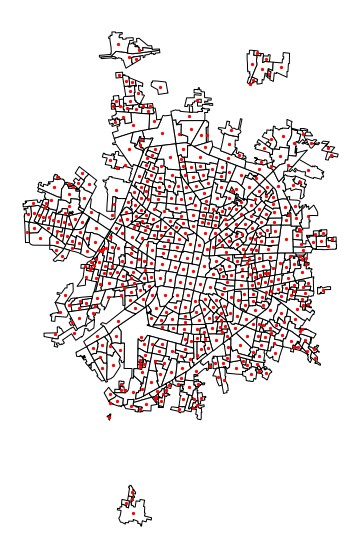

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
ageb_inegi.geometry.plot(ax=ax, color='white', edgecolor='black')
# Need to provide "zorder" to ensure the points are plotted above the polygons
ageb_inegi_centroids.geometry.plot(ax=ax, color='red', markersize=5, zorder=10)
#ax.set_title("Centroids of AGEBs", fontsize=20)
ax.set_axis_off()
plt.show()

In [38]:
ageb_centroids = ageb_inegi_centroids[['CVEGEO', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'NOM_ENT', 'NOM_MUN', 'NOM_LOC', 'nodes', 'geometry']]

In [39]:
ageb_centroids.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,NOM_ENT,NOM_MUN,NOM_LOC,nodes,geometry
0,3104100010028,31,041,0001,0028,Yucatán,Kanasín,Total AGEB urbana,"[1944761419, 1944761432, 4973718571, 194476145...",POINT (-9974147.762 2381725.657)
1,3104100010070,31,041,0001,0070,Yucatán,Kanasín,Total AGEB urbana,"[455039365, 567596048, 2177880357, 455039366, ...",POINT (-9971987.772 2384507.621)
2,3104100010085,31,041,0001,0085,Yucatán,Kanasín,Total AGEB urbana,"[325094958, 3780379884, 430965063, 430965064, ...",POINT (-9972374.247 2383703.006)
3,310410001009A,31,041,0001,009A,Yucatán,Kanasín,Total AGEB urbana,"[325094938, 7348788754, 455035276, 455050013, ...",POINT (-9972920.848 2382988.282)
4,3104100010136,31,041,0001,0136,Yucatán,Kanasín,Total AGEB urbana,"[286974743, 5011841607, 531759536, 531760132, ...",POINT (-9970424.071 2383180.580)


In [40]:
places = [{'county' : 'Merida',
           'state' : 'Yucatan',
           'country' : 'Mexico'},
          {'county' : 'Kanasin',
           'state' : 'Yucatan',
           'country' : 'Mexico'}]

def get_roads_osmnx(places, update=False, proj=False, crs=None):

    dirpath = pathlib.Path('./networks/')
    filepath = dirpath/'merida-kanasin-road.graphml'
    logpath = dirpath/'log'
                                    
    if filepath.exists() and not update:
        G = ox.load_graphml(filepath)
    else:
        # get drivable public streets network, aka road network, without service roads,
        # e.g. private, parking lots, etc.
        # use retain_all if you want to keep all disconnected subgraphs (e.g. when your places aren't adjacent)
        # TODO: It would be nice to setup up a polygon for the city and its surrounding areas, to be sure
        # exactly the location.
        G = ox.graph_from_place(places, network_type='drive')
        ox.save_graphml(G, filepath=filepath, gephi=False)
        
    if proj:
        G = ox.project_graph(G, to_crs=crs)
    
    print(f"Graph created at: {G.graph['created_date']}")
    return G, *ox.graph_to_gdfs(G)
        
#G, nodes, edges = get_roads_osmnx(places, update=False)
G_proj, nodes_proj, edges_proj = get_roads_osmnx(places, update=False, proj=True, crs=3857)

Graph created at: 2021-02-17 11:57:58


In [41]:
# get largest strongly connected component
Gs = ox.utils_graph.get_largest_component(G_proj, strongly=True)

## Create the coarse-grained distance matrix where we store the shortest path length between AGEBs.

The matrix is of size NUMBER OF AGEBS x NUMBER OF AGEBS.

In [42]:
num_agebs = len(ageb_centroids)

In [43]:
distance_matrix = np.zeros((num_agebs, num_agebs))

### Single process implementation

In [21]:
%%time

for source_ageb in range(num_agebs):
    for target_ageb in range(num_agebs):
        source_nodes = ageb_centroids['nodes'].iloc[source_ageb]
        target_nodes = ageb_centroids['nodes'].iloc[target_ageb]
        shortest_paths = []
        
        if (source_ageb == target_ageb):
            min_sp = 0.
        else:
            for source in source_nodes:
                for target in target_nodes:
                    try:
                        sp = nx.shortest_path_length(Gs, source=source, target=target, weight='length', method='dijkstra')
                        shortest_paths.append(sp)
                    except Exception as e:
                        #print('Source AGEB {} to target AGEB {} failed: {}'.format(source_ageb, target_ageb, e))
                        pass
            min_sp = min(shortest_paths, default=0.)
        distance_matrix[source_ageb][target_ageb] = min_sp
        
        print("Source AGEB: " + str(source_ageb))
        print("Target AGEB: " + str(target_ageb))
        #print(min_sp)

Source AGEB: 0
Target AGEB: 0
Source AGEB: 0
Target AGEB: 1
Source AGEB: 0
Target AGEB: 2
Source AGEB: 0
Target AGEB: 3
Source AGEB: 0
Target AGEB: 4
Source AGEB: 0
Target AGEB: 5
Source AGEB: 0
Target AGEB: 6
Source AGEB: 0
Target AGEB: 7
Source AGEB: 0
Target AGEB: 8
Source AGEB: 0
Target AGEB: 9
Source AGEB: 0
Target AGEB: 10
Source AGEB: 0
Target AGEB: 11
Source AGEB: 0
Target AGEB: 12
Source AGEB: 0
Target AGEB: 13
Source AGEB: 0
Target AGEB: 14
Source AGEB: 0
Target AGEB: 15
Source AGEB: 0
Target AGEB: 16
Source AGEB: 0
Target AGEB: 17
Source AGEB: 0
Target AGEB: 18
Source AGEB: 0
Target AGEB: 19
Source AGEB: 0
Target AGEB: 20
Source AGEB: 0
Target AGEB: 21
Source AGEB: 0
Target AGEB: 22
Source AGEB: 0
Target AGEB: 23
Source AGEB: 0
Target AGEB: 24
Source AGEB: 0
Target AGEB: 25
Source AGEB: 0
Target AGEB: 26
Source AGEB: 0
Target AGEB: 27
Source AGEB: 0
Target AGEB: 28
Source AGEB: 0
Target AGEB: 29
Source AGEB: 0
Target AGEB: 30
Source AGEB: 0
Target AGEB: 31
Source AGEB: 0
Tar

KeyboardInterrupt: 

In [34]:
distance_matrix

array([[   0.   , 2927.134, 2062.024, ...,    0.   ,    0.   ,    0.   ],
       [   0.   ,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       [   0.   ,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       ...,
       [   0.   ,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       [   0.   ,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       [   0.   ,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ]])

In [35]:
distance_matrix[0]

array([    0.   ,  2927.134,  2062.024,   853.208,  3516.531,  4799.002,
        4000.059,  4016.211,  6451.744,  6525.373,  2979.715,  3340.862,
        4726.016,  5083.859,  5991.123,  6992.516,  5792.262,  7582.297,
        7288.447,  6970.396,  3367.229,  3549.297,  5890.049,  3363.173,
        1633.254,  1825.488,  7658.275,  8642.642,  8815.915,  8295.608,
        7250.225,  9516.192,  8154.518,  6689.048,  5321.263,  5863.529,
        2458.341,  1750.533,  1041.276,  6764.911,  9649.229,  7032.972,
         744.868,  9777.327,  7286.039,  2218.977,    85.27 ,  9667.623,
        8174.193,  3988.771,  5216.846,  1733.844,   139.964,  7882.963,
        7918.555,  2470.909,  8007.22 ,  8433.46 , 11036.272,    57.04 ,
        7215.662,  7768.09 ,  6699.908,  6076.659,    55.253,   574.224,
       23481.569, 12796.872,  9551.051, 15775.969,  8441.985,  9019.493,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   , 

### Multiprocess (parallel) implementation

In [44]:
import multiprocessing as mp
import itertools

This parallel implementation was adapted from: https://stackoverflow.com/questions/13993674/using-multiprocessing-for-finding-network-paths

In [45]:
def worker(inqueue, output):
    shortest_paths = []
    #count = 0
    for pair in iter(inqueue.get, sentinel):
        source, target = pair
        try:
            sp = nx.shortest_path_length(Gs, source=source, target=target, weight='length', method='dijkstra')
            shortest_paths.append(sp)
        except Exception as e:
            #print('Source AGEB {} to target AGEB {} failed: {}'.format(source_ageb, target_ageb, e))
            pass
            #count += 1
            #if count % 10 == 0:
            #    logger.info('{c}'.format(c = count))
    output.put(shortest_paths)

In [46]:
def test_workers(sources, targets):
    result = []
    inqueue = mp.Queue()
    for source, target in itertools.product(sources, targets):
        inqueue.put((source, target))
    procs = [mp.Process(target = worker, args = (inqueue, output))
             for i in range(mp.cpu_count())]
    for proc in procs:
        proc.daemon = True
        proc.start()
    for proc in procs:    
        inqueue.put(sentinel)
    for proc in procs:
        result.extend(output.get())
    for proc in procs:
        proc.join()
    return result

In [ ]:
%%time

sentinel = None
output = mp.Queue()

for source_ageb in range(num_agebs):
    for target_ageb in range(num_agebs):
        source_nodes = ageb_centroids['nodes'].iloc[source_ageb]
        target_nodes = ageb_centroids['nodes'].iloc[target_ageb]
        #shortest_paths = []
        
        if (source_ageb == target_ageb):
            min_sp = 0.
        else:
            shortest_paths = test_workers(source_nodes, target_nodes)
            min_sp = min(shortest_paths, default = 0.)
            
        distance_matrix[source_ageb][target_ageb] = min_sp
        
        print("Source AGEB: " + str(source_ageb))
        print("Target AGEB: " + str(target_ageb))
        print(min_sp)

Source AGEB: 0
Target AGEB: 0
0.0
Source AGEB: 0
Target AGEB: 1
2927.134
Source AGEB: 0
Target AGEB: 2
2062.024
Source AGEB: 0
Target AGEB: 3
853.208
Source AGEB: 0
Target AGEB: 4
3516.5310000000004
Source AGEB: 0
Target AGEB: 5
4799.002
Source AGEB: 0
Target AGEB: 6
4000.059
Source AGEB: 0
Target AGEB: 7
4016.211
Source AGEB: 0
Target AGEB: 8
6451.743999999998
Source AGEB: 0
Target AGEB: 9
6525.3730000000005
Source AGEB: 0
Target AGEB: 10
2979.7149999999997
Source AGEB: 0
Target AGEB: 11
3340.862
Source AGEB: 0
Target AGEB: 12
4726.016
Source AGEB: 0
Target AGEB: 13
5083.8589999999995
Source AGEB: 0
Target AGEB: 14
5991.123
Source AGEB: 0
Target AGEB: 15
6992.516
Source AGEB: 0
Target AGEB: 16
5792.262000000001
Source AGEB: 0
Target AGEB: 17
7582.2970000000005
Source AGEB: 0
Target AGEB: 18
7288.447000000002
Source AGEB: 0
Target AGEB: 19
6970.395999999997
Source AGEB: 0
Target AGEB: 20
3367.229
Source AGEB: 0
Target AGEB: 21
3549.297
Source AGEB: 0
Target AGEB: 22
5890.049
Source AGE

In [ ]:
distance_matrix